In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

## JSON

elections = pd.read_csv("elections.csv")
elections.to_json("elections.json") # orient='table' or 'records' or 'values'
!python -m json.tool elections.json 

## Hierarchical Data

A lot of structured data isn't in CSV format, but in HTML, XML, JSON, YAML, etc. JSON might have a structure that Pandas can't read directly.

Here's an example: a group of people collected information about US congressional legislators in YAML format.

https://github.com/unitedstates/congress-legislators

Here's one of the data files:

https://github.com/unitedstates/congress-legislators/blob/master/legislators-current.yaml

In [2]:
import requests
from pathlib import Path

legislators_path = 'legislators-current.yaml'
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'

def download(url, path):
    """Download the contents of a URL to a local file."""
    path = Path(path) # If path was a string, now it's a Path
    if not path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(url)
        with path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
        
download(base_url + legislators_path, legislators_path)

In [3]:
import yaml

legislators = yaml.load(open(legislators_path))
len(legislators)

539

In [4]:
legislators[0]

{'id': {'bioguide': 'B000944',
  'thomas': '00136',
  'lis': 'S307',
  'govtrack': 400050,
  'opensecrets': 'N00003535',
  'votesmart': 27018,
  'fec': ['H2OH13033', 'S6OH00163'],
  'cspan': 5051,
  'wikipedia': 'Sherrod Brown',
  'house_history': 9996,
  'ballotpedia': 'Sherrod Brown',
  'maplight': 168,
  'icpsr': 29389,
  'wikidata': 'Q381880',
  'google_entity_id': 'kg:/m/034s80'},
 'name': {'first': 'Sherrod',
  'last': 'Brown',
  'official_full': 'Sherrod Brown'},
 'bio': {'birthday': '1952-11-09', 'gender': 'M', 'religion': 'Lutheran'},
 'terms': [{'type': 'rep',
   'start': '1993-01-05',
   'end': '1995-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1995-01-04',
   'end': '1997-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1997-01-07',
   'end': '1999-01-03',
   'state': 'OH',
   'district': 13,
   'party': 'Democrat'},
  {'type': 'rep',
   'start': '1999-01-06',
   'end

In [5]:
x = legislators[0]
x['id']

{'bioguide': 'B000944',
 'thomas': '00136',
 'lis': 'S307',
 'govtrack': 400050,
 'opensecrets': 'N00003535',
 'votesmart': 27018,
 'fec': ['H2OH13033', 'S6OH00163'],
 'cspan': 5051,
 'wikipedia': 'Sherrod Brown',
 'house_history': 9996,
 'ballotpedia': 'Sherrod Brown',
 'maplight': 168,
 'icpsr': 29389,
 'wikidata': 'Q381880',
 'google_entity_id': 'kg:/m/034s80'}

In [6]:
x['name']

{'first': 'Sherrod', 'last': 'Brown', 'official_full': 'Sherrod Brown'}

In [7]:
x['bio']

{'birthday': '1952-11-09', 'gender': 'M', 'religion': 'Lutheran'}

In [8]:
from datetime import datetime

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

to_date(x['bio']['birthday'])

datetime.datetime(1952, 11, 9, 0, 0)

In [9]:
leg_df = pd.DataFrame(
    columns=['id', 'first', 'last', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           to_date(x['bio']['birthday'])] for x in legislators])
leg_df.head()

,id,first,last,birthday
0,B000944,Sherrod,Brown,1952-11-09
1,C000127,Maria,Cantwell,1958-10-13
2,C000141,Benjamin,Cardin,1943-10-05
3,C000174,Thomas,Carper,1947-01-23
4,C001070,Robert,Casey,1960-04-13


In [10]:
datetime.now() - leg_df.loc[0, 'birthday']

Timedelta('24189 days 14:25:57.750825')

In [11]:
leg_df['age'] = (datetime.now() - leg_df['birthday']).apply(lambda age: age.days/365)
leg_df.head()

,id,first,last,birthday,age
0,B000944,Sherrod,Brown,1952-11-09,66.271233
1,C000127,Maria,Cantwell,1958-10-13,60.342466
2,C000141,Benjamin,Cardin,1943-10-05,75.375342
3,C000174,Thomas,Carper,1947-01-23,72.071233
4,C001070,Robert,Casey,1960-04-13,58.841096


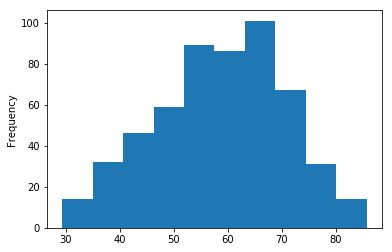

In [12]:
leg_df['age'].plot(kind='hist');

## Missing Values

In [13]:
leg_df['religion'] = [x['bio'].get('religion') for x in legislators]
leg_df.head()

,id,first,last,birthday,age,religion
0,B000944,Sherrod,Brown,1952-11-09,66.271233,Lutheran
1,C000127,Maria,Cantwell,1958-10-13,60.342466,Roman Catholic
2,C000141,Benjamin,Cardin,1943-10-05,75.375342,Jewish
3,C000174,Thomas,Carper,1947-01-23,72.071233,Presbyterian
4,C001070,Robert,Casey,1960-04-13,58.841096,None


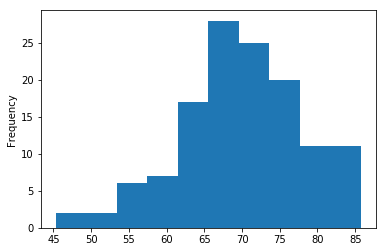

In [14]:
leg_df[leg_df['religion'].notnull()]['age'].plot(kind='hist');

## Joins

In [15]:
comm_path = 'committees-current.yaml'
comm_membership_path = 'committee-membership-current.yaml'
for p in [comm_path, comm_membership_path]:
    download(base_url + p, p)
comms = yaml.load(open(comm_path))
comm_membership = yaml.load(open(comm_membership_path))
print(len(comms), len(comm_membership))

47 217


In [16]:
comms[0]

{'type': 'house',
 'name': 'House Committee on Agriculture',
 'url': 'https://agriculture.house.gov/',
 'minority_url': 'https://democrats-agriculture.house.gov/',
 'thomas_id': 'HSAG',
 'house_committee_id': 'AG',
 'subcommittees': [{'name': 'Conservation and Forestry',
   'thomas_id': '15',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Commodity Exchanges, Energy, and Credit',
   'thomas_id': '22',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'General Farm Commodities and Risk Management',
   'thomas_id': '16',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Livestock and Foreign Agriculture',
   'thomas_id': '29',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
  {'name': 'Biotechnology, Horticulture, and Research',
   'thomas_id': '14',
   'address': '1301 LHOB; Washington, DC 20515',
   'phone': '(202) 225-2171'},
 

In [17]:
comm_df = pd.DataFrame(
    columns=['name', 'thomas_id', 'type'],
    data=[[c['name'], c['thomas_id'], c['type']] for c in comms]
)
comm_df.head()

,name,thomas_id,type
0,House Committee on Agriculture,HSAG,house
1,House Committee on Appropriations,HSAP,house
2,House Committee on Armed Services,HSAS,house
3,House Committee on Financial Services,HSBA,house
4,House Committee on the Budget,HSBU,house


In [18]:
comm_membership.keys()

dict_keys(['HLIG', 'HLIG01', 'HLIG02', 'HLIG03', 'HLIG04', 'HSAG', 'HSAG03', 'HSAG14', 'HSAG15', 'HSAG16', 'HSAG22', 'HSAG29', 'HSAP', 'HSAP01', 'HSAP02', 'HSAP04', 'HSAP06', 'HSAP07', 'HSAP10', 'HSAP15', 'HSAP18', 'HSAP19', 'HSAP20', 'HSAP23', 'HSAP24', 'HSAS', 'HSAS02', 'HSAS03', 'HSAS06', 'HSAS25', 'HSAS26', 'HSAS28', 'HSAS29', 'HSBA', 'HSBA01', 'HSBA04', 'HSBA09', 'HSBA15', 'HSBA16', 'HSBA20', 'HSBU', 'HSED', 'HSED02', 'HSED10', 'HSED13', 'HSED14', 'HSFA', 'HSFA05', 'HSFA07', 'HSFA13', 'HSFA14', 'HSFA16', 'HSFA18', 'HSGO', 'HSGO06', 'HSGO24', 'HSGO25', 'HSGO27', 'HSGO28', 'HSGO29', 'HSHA', 'HSHM', 'HSHM05', 'HSHM07', 'HSHM08', 'HSHM09', 'HSHM11', 'HSHM12', 'HSIF', 'HSIF02', 'HSIF03', 'HSIF14', 'HSIF16', 'HSIF17', 'HSIF18', 'HSII', 'HSII06', 'HSII10', 'HSII13', 'HSII15', 'HSII24', 'HSJU', 'HSJU01', 'HSJU03', 'HSJU05', 'HSJU08', 'HSJU10', 'HSPW', 'HSPW02', 'HSPW05', 'HSPW07', 'HSPW12', 'HSPW13', 'HSPW14', 'HSRU', 'HSRU02', 'HSRU04', 'HSSM', 'HSSM23', 'HSSM24', 'HSSM25', 'HSSM26', 'HS

In [19]:
comm_membership['HSAG'][0]

{'name': 'K. Michael Conaway',
 'party': 'majority',
 'rank': 1,
 'title': 'Chair',
 'thomas': '01805',
 'bioguide': 'C001062'}

In [20]:
member_df = pd.DataFrame(
    columns=['comm_id', 'leg_id'],
    data=[[c, m['bioguide']] for c, members in comm_membership.items() for m in members]
)
member_df.head()

,comm_id,leg_id
0,HLIG,N000181
1,HLIG,C001062
2,HLIG,K000210
3,HLIG,T000463
4,HLIG,W000815


In [21]:
member_comm = member_df.merge(comm_df, left_on='comm_id', right_on='thomas_id')
member_comm.head()

,comm_id,leg_id,name,thomas_id,type
0,HLIG,N000181,House Permanent Select Committee on Intelligence,HLIG,house
1,HLIG,C001062,House Permanent Select Committee on Intelligence,HLIG,house
2,HLIG,K000210,House Permanent Select Committee on Intelligence,HLIG,house
3,HLIG,T000463,House Permanent Select Committee on Intelligence,HLIG,house
4,HLIG,W000815,House Permanent Select Committee on Intelligence,HLIG,house


In [22]:
comm_sizes = member_comm['name'].value_counts()
comm_sizes

House Committee on Energy and Commerce                            48
House Committee on Armed Services                                 48
House Committee on Transportation and Infrastructure              47
House Committee on Appropriations                                 44
House Committee on Financial Services                             43
House Committee on Agriculture                                    40
House Committee on Foreign Affairs                                38
House Committee on Natural Resources                              37
House Committee on Oversight and Reform                           34
House Committee on Science, Space, and Technology                 32
Senate Committee on Appropriations                                31
House Committee on Education and Labor                            30
House Committee on the Judiciary                                  29
House Committee on Ways and Means                                 28
House Committee on the Budget     

In [23]:
df = member_comm.merge(leg_df, left_on='leg_id', right_on='id')
df.head()

,comm_id,leg_id,name,thomas_id,type,id,first,last,birthday,age,religion
0,HLIG,N000181,House Permanent Select Committee on Intelligence,HLIG,house,N000181,Devin,Nunes,1973-10-01,45.364384,Roman Catholic
1,HSWM,N000181,House Committee on Ways and Means,HSWM,house,N000181,Devin,Nunes,1973-10-01,45.364384,Roman Catholic
2,HLIG,C001062,House Permanent Select Committee on Intelligence,HLIG,house,C001062,K.,Conaway,1948-06-11,70.687671,Baptist
3,HSAG,C001062,House Committee on Agriculture,HSAG,house,C001062,K.,Conaway,1948-06-11,70.687671,Baptist
4,HSAS,C001062,House Committee on Armed Services,HSAS,house,C001062,K.,Conaway,1948-06-11,70.687671,Baptist


In [24]:
comm_ages = df['age'].groupby(df['name']).mean().sort_values()
comm_ages

name
House Permanent Select Committee on Intelligence                  54.800457
House Committee on House Administration                           54.911872
Joint Economic Committee                                          55.162192
House Committee on the Budget                                     56.561252
House Committee on Armed Services                                 56.862329
House Committee on Veterans' Affairs                              57.073828
House Committee on Homeland Security                              57.305973
House Committee on the Judiciary                                  58.057912
House Committee on Foreign Affairs                                59.072603
House Committee on Ethics                                         59.106849
House Committee on Oversight and Reform                           59.187913
House Committee on Financial Services                             59.193183
House Committee on Agriculture                                    59.617877
Senate 

In [25]:
leg_df['age'].mean()

58.620133682364596

In [26]:
member_count = member_df['leg_id'].value_counts().to_frame().reset_index()
member_count.head()

,index,leg_id
0,L000174,24
1,S000320,23
2,M000934,22
3,C001047,22
4,U000039,21


In [27]:
member_count.columns = ['id', 'num_comms']
member_count.head()

,id,num_comms
0,L000174,24
1,S000320,23
2,M000934,22
3,C001047,22
4,U000039,21


In [28]:
df = leg_df.merge(member_count, left_on='id', right_on='id')
df.head()

,id,first,last,birthday,age,religion,num_comms
0,B000944,Sherrod,Brown,1952-11-09,66.271233,Lutheran,14
1,C000127,Maria,Cantwell,1958-10-13,60.342466,Roman Catholic,16
2,C000141,Benjamin,Cardin,1943-10-05,75.375342,Jewish,14
3,C000174,Thomas,Carper,1947-01-23,72.071233,Presbyterian,12
4,C001070,Robert,Casey,1960-04-13,58.841096,None,12


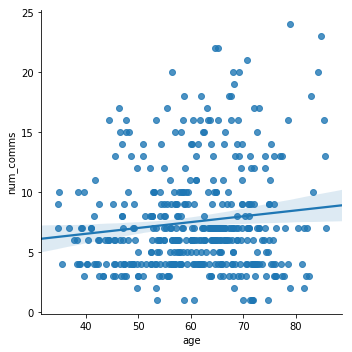

In [29]:
import seaborn as sns
sns.lmplot(x='age', y='num_comms', data=df, fit_reg=True);